# 1. Connect to drive and Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/lung-CT-npy

/content/drive/MyDrive/Colab Notebooks/lung-CT-npy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import pickle
from torch.optim.lr_scheduler import ReduceLROnPlateau




if torch.backends.mps.is_available():
    print("MPS is available.")
    device = torch.device("mps")
elif torch.cuda.is_available():
    print("CUDA is available.")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")

print("device: {}".format(device))

CUDA is available.
device: cuda


# 2. Dataset and Train Loader

In [ ]:
class LungCTDataset(Dataset):
  def __init__(self, data_pickle, mask_pickle):
    super(LungCTDataset, self).__init__()

    with open(data_pickle, 'rb') as f:
      self.data = pickle.load(f)
    with open(mask_pickle, 'rb') as f:
      self.mask = pickle.load(f)

    # preload all data and mask in RAM
    self.data = [np.load(data) for data in self.data]
    self.mask = [np.load(mask) for mask in self.mask]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    # load scan and mask in torch tensor format
    scan = torch.tensor(self.data[idx]).to(device).float()
    mask = torch.tensor(self.mask[idx]).to(device).float()

    # add channel dimension
    scan = scan.unsqueeze(0)
    mask = mask.unsqueeze(0)

    return scan, mask

In [ ]:
# load datasets from disk
cancer_train_dataset = torch.load('/content/drive/MyDrive/Colab Notebooks/lung-CT-npy/cancer_train_dataset.pth')
cancer_val_dataset = torch.load('/content/drive/MyDrive/Colab Notebooks/lung-CT-npy/cancer_val_dataset.pth')
cancer_test_dataset = torch.load('/content/drive/MyDrive/Colab Notebooks/lung-CT-npy/cancer_test_dataset.pth')

# print the size of each dataset
print("cancer_train_dataset: {}".format(len(cancer_train_dataset)))
print("cancer_val_dataset: {}".format(len(cancer_val_dataset)))
print("cancer_test_dataset: {}".format(len(cancer_test_dataset)))


<ipython-input-5-0c6c73902e21>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cancer_train_dataset = torch.load('/content/drive/MyDrive/Colab Notebooks/lung-CT-npy/cancer_

cancer_train_dataset: 1153
cancer_val_dataset: 247
cancer_test_dataset: 248


# 3. Unet

## Original Unet 4*4 with Layer Norm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=32, input_size=(256, 256)):
        super(UNet, self).__init__()
        features = init_features
        H, W = input_size  # Extract initial spatial dimensions

        # Precompute spatial dimensions after each pooling layer
        self.spatial_dims = {
            "enc1": (H, W),
            "enc2": (H // 2, W // 2),
            "enc3": (H // 4, W // 4),
            "enc4": (H // 8, W // 8),
            "bottleneck": (H // 16, W // 16),
        }

        # Encoding path
        self.encoder1 = UNet._block(in_channels, features, spatial_dims=self.spatial_dims["enc1"])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, spatial_dims=self.spatial_dims["enc2"])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, spatial_dims=self.spatial_dims["enc3"])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, spatial_dims=self.spatial_dims["enc4"])
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = UNet._block(features * 8, features * 16, spatial_dims=self.spatial_dims["bottleneck"])

        # Decoding path
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = UNet._block(features * 8 * 2, features * 8, spatial_dims=self.spatial_dims["enc4"])
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNet._block(features * 4 * 2, features * 4, spatial_dims=self.spatial_dims["enc3"])
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block(features * 2 * 2, features * 2, spatial_dims=self.spatial_dims["enc2"])
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block(features * 2, features, spatial_dims=self.spatial_dims["enc1"])

        self.conv = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.conv(dec1)

    @staticmethod
    def _block(in_channels, features, spatial_dims):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1),
            nn.LayerNorm([features, *spatial_dims]),  # Normalize over channels and spatial dimensions
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1),
            nn.LayerNorm([features, *spatial_dims]),  # Normalize again
            nn.ReLU(inplace=True)
        )


# 4. Loss Functions


In [ ]:
# define combo loss, dice+focal loss
class ComboLoss(nn.Module):
    def __init__(self, smooth = 1e-5, alpha=0.5, gamma=2):
        super(ComboLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth

    def dice_loss(self, pred, target):
        pred = torch.sigmoid(pred) #if pred.max() > 1 else pred

        #print(pred.shape)
        #print(target.shape)

        # flatten tensors along the batch dimension
        pred_flat = pred.view(pred.size(0), -1)
        target_flat = target.view(target.size(0), -1)

        # calculate intersection and union for the batch
        intersection = (pred_flat * target_flat).sum(dim=1)
        union = pred_flat.sum(dim=1) + target_flat.sum(dim=1)
        dice_score = (2. * intersection + self.smooth) / (union + self.smooth)

        return 1 - dice_score.mean()

    def focal_loss(self, pred, target):
        #pred = torch.sigmoid(pred) #if pred.max() > 1 else pred

        # flatten tensors along the batch dimension
        pred_flat = pred.view(pred.size(0), -1)
        target_flat = target.view(target.size(0), -1)

        # calculate binary cross entropy
        bce = F.binary_cross_entropy_with_logits(pred_flat, target_flat, reduction='none')

        # calculate pt
        pt = torch.exp(-bce)

        # calculate alpha_t
        alpha_t = self.alpha * target_flat + (1 - self.alpha) * (1 - target_flat)

        # calculate focal loss
        focal = alpha_t * (1 - pt) ** self.gamma * bce

        return focal.mean()

    def forward(self, pred, target):
        dice = self.dice_loss(pred, target)
        focal = self.focal_loss(pred, target)

        return dice + focal




# 5.Training


### Train Function

In [ ]:
# training function
def train(model, train_loader_1, val_loader_1, num_epochs=5, lr=0.001, alpha=0.75):

    # save the losses for each epoch for future visualization
    train_losses = []
    val_losses = []


    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=1)
    # use DiceLoss
    criterion = ComboLoss(smooth = 1e-5, alpha=alpha, gamma=2) # potential tuning alpha

    # move model to device
    model.to(device)

    # initialize early stopping
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Initialize previous learning rate tracker
    prev_lr = optimizer.param_groups[0]['lr']

    # training loop
    for epoch in range(num_epochs):

        model.train()
        train_loss = 0.0
        for scans, masks in train_loader_1:

            # data augmentation
            # flip the scans and masks along the y-axis
            if np.random.rand() > 0.5:
                scans = torch.flip(scans, dims=[2])
                masks = torch.flip(masks, dims=[2])

            # flip the scans and masks along the x-axis
            if np.random.rand() > 0.5:
                scans = torch.flip(scans, dims=[3])
                masks = torch.flip(masks, dims=[3])

            # add random noise to the scans
            if np.random.rand() > 0.5:
                noise = torch.randn_like(scans) * 0.1
                scans = scans + noise

            # rotate the scans and masks by 90 degrees
            if np.random.rand() > 0.5:
                scans = torch.rot90(scans, k=1, dims=[2, 3]).contiguous()
                masks = torch.rot90(masks, k=1, dims=[2, 3]).contiguous()
                #print("rotate")




            # move the data to the device
            inputs, targets = scans.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()


        # validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for scans, masks in val_loader_1:
                inputs, targets = scans.to(device), masks.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()


        # save the losses for future visualization
        train_losses.append(train_loss/(len(train_loader_1)))
        val_losses.append(val_loss/(len(val_loader_1)))

        # Step the scheduler
        scheduler.step(val_losses[-1])

        # Get the current learning rate
        current_lr = optimizer.param_groups[0]['lr']

        # Print only if the learning rate has changed
        if current_lr != prev_lr:
            print(f"Epoch {epoch + 1}: Learning rate changed to {current_lr}")
            prev_lr = current_lr


        # print the epoch, the training loss, and the validation loss, every 10 epochs, and the last epoch
        if (epoch) % 5 == 0:
            print(f"\n{epoch+1} Training loss: {train_loss/(len(train_loader_1))} Validation loss: {val_loss/(len(val_loader_1))}")
            # show the output of the first image in the batch, cmap jet, show colorbar
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            # output to sigmoid
            plt.imshow(torch.sigmoid(outputs[0, 0]).cpu().numpy(), cmap='jet')
            plt.colorbar()
            plt.title('Output')
            plt.axis('off')
            plt.subplot(1, 2, 2)
            # overlay the mask on the input
            plt.imshow(inputs[0, 0].cpu().numpy(), cmap='gray')
            plt.imshow(targets[0, 0].cpu().numpy(), cmap='jet', alpha=0.5)
            plt.colorbar()
            plt.title('Target')
            plt.axis('off')
            plt.show()

        # early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
            print(f'No improvement for {epochs_no_improve} epochs')

        if epochs_no_improve == 10:
            print('Early stopping!')
            model.load_state_dict(best_model_state)
            break

    return model, train_losses, val_losses


## Training

In [ ]:
# main dir
main_dir = '/content/drive/MyDrive/Colab Notebooks/lung-CT-npy'


# save the model
model_name = '11_24_batch_1_lr-3_alpha75_cancer_only_layer_norm.pth'
model_path = os.path.join(main_dir, model_name)

# create model instance
model = UNet(in_channels=1, out_channels=1, init_features=32)

#model.load_state_dict(torch.load(model_path))

# hyperparameters
batch_size = 1
num_epochs = 250
lr = 1e-3 # potential fix
alpha = 0.75


# training and validation loaders
train_loader_1 = DataLoader(cancer_train_dataset, batch_size=batch_size, shuffle=True)
# train_loader_0 = DataLoader(non_cancer_train_dataset, batch_size=1, shuffle=True)

val_loader_1 = DataLoader(cancer_val_dataset, batch_size=batch_size, shuffle=True)
# val_loader_0 = DataLoader(non_cancer_val_dataset, batch_size=1, shuffle=True)

In [ ]:
# train the model
model, train_losses, val_losses = train(model, train_loader_1, val_loader_1, num_epochs=num_epochs, lr=lr, alpha = alpha)

Output hidden; open in https://colab.research.google.com to view.

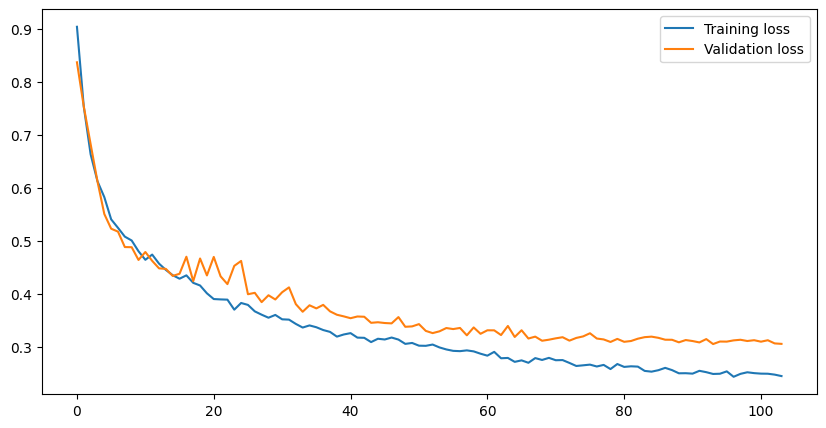

Best validation loss: 0.30596808537931336
Best validation loss epoch: 93


In [ ]:
# at the end of the training, plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

# print the best validation loss
print(f"Best validation loss: {min(val_losses)}")
# print the index of the best validation loss
print(f"Best validation loss epoch: {val_losses.index(min(val_losses))}")

# save the model
#model_name = '11_16_2024_4by4_batch3+1_lr1e-4_alpha0-8.pth'
#model_path = os.path.join(main_dir, model_name)
torch.save(model.state_dict(), model_path)

In [ ]:
# Instantiate and test
test_loader_1 = DataLoader(cancer_test_dataset, batch_size=1, shuffle=True)
# test_loader_0 = DataLoader(non_cancer_test_dataset, batch_size=1, shuffle=True)

# test the model on the test set
criterion = ComboLoss(smooth = 1e-5, alpha=0.75, gamma=2)
model.eval()
test_loss = 0.0
dice_scores = []
with torch.no_grad():
    for scans, masks in test_loader_1:
        inputs, targets = scans.to(device), masks.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        # calculate the dice coefficient for each scan
        outputs = torch.sigmoid(outputs)
        outputs[outputs > 0.5] = 1
        outputs[outputs <= 0.5] = 0
        targets[targets > 0.5] = 1
        targets[targets <= 0.5] = 0
        for i in range(inputs.shape[0]):
            intersection = np.logical_and(targets[i, 0].cpu().numpy(), outputs[i, 0].cpu().numpy())
            union = targets[i, 0].sum().cpu().numpy() + outputs[i, 0].sum().cpu().numpy()
            iou_score = (2*np.sum(intersection) + 1e-7) / (np.sum(union) + 1e-7)
            dice_scores.append(iou_score)

# print the test loss
print(f"Test loss: {test_loss/(len(test_loader_1))}")

# calculate the average dice score
dice_score = np.mean(dice_scores)
# print the dice score
print(f"Avg Dice score: {dice_score}")




Test loss: 0.2776980314163431
Avg Dice score: 0.7313219537845381
